In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 603, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 603 (delta 131), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (603/603), 199.38 KiB | 854.00 KiB/s, done.
Resolving deltas: 100% (305/305), done.
Installing RAPIDS remaining 25.08 libraries
Using Python 3.12.12 environment at: /usr
Resolved 179 packages in 11.93s
Prepared 41 packages in 47.33s
Uninstalled 31 packages in 962ms
Installed 41 packages in 431ms
 - bokeh==3.7.3
 + bokeh==3.6.3
 + cucim-cu12==25.8.0
 + cuda-bindings==12.9.4
 + cuda-pathfinder==1.3.1
 - cuda-python==12.6.2.post1
 + cuda-python==12.9.4
 - cudf-cu12==25.6.0 (from https://pypi.nvidia.com/cudf-cu12/cudf_cu12-25.6.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl)
 + cudf-cu12==25.8.0
 + cugraph-cu12==25.8.0
 - cuml-cu12==25.6.0
 + cuml-cu12==25.8.0
 - cuvs-cu12==25.6.1
 + cuvs-cu12==25.8.0
 +

In [ ]:
import cudf
import cuml
import dask_cudf


In [ ]:
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.linear_model import LogisticRegression as cuLR
from cuml.preprocessing import StandardScaler as cuScaler
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import numpy as np
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve,
                             average_precision_score, roc_curve, f1_score,
                             accuracy_score, precision_score, recall_score)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

import subprocess
gpu_info = subprocess.check_output(['nvidia-smi']).decode('utf-8')
print("GPU Information:")
print(gpu_info)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("\n✓ All libraries imported successfully!")
print(f"cuDF version: {cudf.__version__}")
print(f"cuML version: {cuml.__version__}")
print(f"XGBoost version: {xgb.__version__}")


GPU Information:
Wed Oct 29 08:27:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------------

In [ ]:
# ============================================================================
# CELL 3: Load Data from Google Drive in Batches - GPU Optimized
# ============================================================================

folder_path = '/content/drive/MyDrive/CNS_DATASET/cleaned_data_json'

print("Loading data using cuDF (GPU-accelerated) in batches...")

# Define batches (here, 10 files split into 2 batches of 5 files each)
batches = [range(0, 5), range(5, 10)]

# List to store cuDF DataFrames for each batch
gdfs = []

for batch_idx, batch_files in enumerate(batches, start=1):
    print(f"\nProcessing batch {batch_idx}...")
    batch_data = []

    for i in batch_files:
        file_path = f'{folder_path}/bank_{i}.json'
        print(f"  Loading {file_path}...")
        try:
            with open(file_path, 'r') as f:
                json_data = json.load(f)
                records = json_data['records']
                batch_data.extend(records)
            print(f"    ✓ Loaded {len(records)} transactions")
        except FileNotFoundError:
            print(f"    ✗ File not found: {file_path}")
        except Exception as e:
            print(f"    ✗ Error loading {file_path}: {e}")

    # Convert batch to cuDF and append to list
    batch_gdf = cudf.DataFrame(batch_data)
    gdfs.append(batch_gdf)

    # Delete Python list to free CPU memory
    del batch_data
    print(f"  Batch {batch_idx} shape: {batch_gdf.shape}")

# Optionally, concatenate all batches into a single cuDF DataFrame
gdf = cudf.concat(gdfs, ignore_index=True)
# Free batch list if no longer needed
del gdfs

print(f"\n{'='*60}")
print(f"Total transactions loaded (GPU): {len(gdf)}")
print(f"{'='*60}")
print(f"Memory usage (GPU): {gdf.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst few rows:")
gdf.head()


Loading data using cuDF (GPU-accelerated) in batches...

Processing batch 1...
  Loading /content/drive/MyDrive/CNS_DATASET/cleaned_data_json/bank_0.json...
    ✓ Loaded 692417 transactions
  Loading /content/drive/MyDrive/CNS_DATASET/cleaned_data_json/bank_1.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/CNS_DATASET/cleaned_data_json/bank_2.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/CNS_DATASET/cleaned_data_json/bank_3.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/CNS_DATASET/cleaned_data_json/bank_4.json...
    ✓ Loaded 692416 transactions
  Batch 1 shape: (3462081, 22)

Processing batch 2...
  Loading /content/drive/MyDrive/CNS_DATASET/cleaned_data_json/bank_5.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/CNS_DATASET/cleaned_data_json/bank_6.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/CNS_DATASET/cleaned_data_json/bank_7.json...
    ✓ Loaded

,Timestamp,From Bank,From_Account,To Bank,To_Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,...,Sender_Bank ID,Sender_Account_Number,Sender_Entity ID,Sender_Entity Name,Receiver_Bank Name,Receiver_Bank ID,Receiver_Account_Number,Receiver_Entity ID,Receiver_Entity Name,Bank_Partition
0,2022/09/01 00:24,12,8006ADD30,12,8006ADD30,6473.62,US Dollar,6473.62,US Dollar,Reinvestment,...,12,8006ADD30,8011BBB00,Partnership #3,National Bank of Columbus,12,8006ADD30,8011BBB00,Partnership #3,0
1,2022/09/01 00:29,3618,800929EA0,1277,800929EF0,0.05,US Dollar,0.05,US Dollar,ACH,...,3618,800929EA0,8012FB580,Sole Proprietorship #3,First Bank of Huron,1277,800929EF0,80153E7D0,Sole Proprietorship #4,0
2,2022/09/01 00:08,394,80093BDB0,21414,80092A6C0,64335.00,US Dollar,64335.00,US Dollar,ACH,...,394,80093BDB0,800EBBCA0,Partnership #5,Arbor Community Bank,21414,80092A6C0,8010C79A0,Partnership #6,0
3,2022/09/01 00:14,394,80093BDB0,394,80093BDB0,14903.78,US Dollar,14903.78,US Dollar,Reinvestment,...,394,80093BDB0,800EBBCA0,Partnership #5,Savings Bank of Detroit,394,80093BDB0,800EBBCA0,Partnership #5,0
4,2022/09/01 00:18,21414,80093CED0,29264,81013D0A0,0.78,US Dollar,0.78,US Dollar,Credit Card,...,21414,80093CED0,8012A59C0,Corporation #4,Bank of Lincoln,29264,81013D0A0,800FC7F90,Sole Proprietorship #9195,0


In [ ]:

# ============================================================================
# CELL 4: Initial Data Exploration - GPU
# ============================================================================
print("="*80)
print("DATA OVERVIEW (GPU-accelerated)")
print("="*80)
print(f"\nDataset Shape: {gdf.shape}")
print(f"\nColumn Names and Types:")
print(gdf.dtypes)

print(f"\nNull Values:")
print(gdf.isnull().sum())

print(f"\nBasic Statistics:")
print(gdf.describe())

# Check class distribution
print(f"\n{'='*80}")
print("CLASS DISTRIBUTION")
print("="*80)

class_dist = gdf['Is Laundering'].value_counts().reindex([0, 1], fill_value=0)

total = len(gdf)

print(f"\nPercentage:")
for idx in [0, 1]:
    count = class_dist[idx]
    print(f"Is Laundering {idx}: {(count/total)*100:.2f}%")


DATA OVERVIEW (GPU-accelerated)

Dataset Shape: (6924161, 22)

Column Names and Types:
Timestamp                   object
From Bank                    int64
From_Account                object
To Bank                      int64
To_Account                  object
Amount Received            float64
Receiving Currency          object
Amount Paid                float64
Payment Currency            object
Payment Format              object
Is Laundering                int64
Sender_Bank Name            object
Sender_Bank ID               int64
Sender_Account_Number       object
Sender_Entity ID            object
Sender_Entity Name          object
Receiver_Bank Name          object
Receiver_Bank ID             int64
Receiver_Account_Number     object
Receiver_Entity ID          object
Receiver_Entity Name        object
Bank_Partition               int64
dtype: object

Null Values:
Timestamp                  0
From Bank                  0
From_Account               0
To Bank                    0

In [ ]:
# ============================================================================
# CELL 5: Feature Engineering - GPU Accelerated (cuDF + CuPy)
# ============================================================================
import cupy as cp

print("\nStarting feature engineering with cuDF (GPU-accelerated)...")

# --------------------------
# Convert timestamp and extract features
# --------------------------
gdf['Timestamp'] = cudf.to_datetime(gdf['Timestamp'], format='%Y/%m/%d %H:%M')
gdf['Hour'] = gdf['Timestamp'].dt.hour
gdf['DayOfWeek'] = gdf['Timestamp'].dt.weekday
gdf['Month'] = gdf['Timestamp'].dt.month
gdf['Day'] = gdf['Timestamp'].dt.day

# Time-based features
gdf['IsWeekend'] = (gdf['DayOfWeek'] >= 5).astype('int32')
gdf['IsNightTime'] = ((gdf['Hour'] >= 22) | (gdf['Hour'] <= 6)).astype('int32')

# --------------------------
# Same bank/account/entity features
# --------------------------
gdf['Same_Bank'] = (gdf['From Bank'] == gdf['To Bank']).astype('int32')
gdf['Same_Account'] = (gdf['From_Account'] == gdf['To_Account']).astype('int32')
gdf['Same_Entity'] = (gdf['Sender_Entity ID'] == gdf['Receiver_Entity ID']).astype('int32')

# --------------------------
# Amount features (GPU math with CuPy)
# --------------------------
for col in ['Amount Received', 'Amount Paid']:
    gdf[f'Log_{col.replace(" ", "_")}'] = cudf.Series(cp.log1p(gdf[col].to_cupy()))

gdf['Amount_Difference'] = (gdf['Amount Received'] - gdf['Amount Paid']).abs()
gdf['Round_Amount_Received'] = (gdf['Amount Received'] % 1000 == 0).astype('int32')
gdf['Round_Amount_Paid'] = (gdf['Amount Paid'] % 1000 == 0).astype('int32')
gdf['Below_Threshold'] = ((gdf['Amount Received'] > 9000) & (gdf['Amount Received'] < 10000)).astype('int32')

# --------------------------
# Currency mismatch
# --------------------------
gdf['Currency_Mismatch'] = (gdf['Receiving Currency'] != gdf['Payment Currency']).astype('int32')

# --------------------------
# Encode categorical variables on GPU
# --------------------------
categorical_cols = ['Payment Format', 'Receiving Currency', 'Payment Currency']
for col in categorical_cols:
    gdf[f'{col}_Encoded'] = gdf[col].astype('category').cat.codes

# --------------------------
# Final reporting
# --------------------------
print(f"✓ Feature engineering complete!")
print(f"New shape: {gdf.shape}")
gpu_mem_mb = gdf.memory_usage(deep=True).sum() / 1024**2
print(f"GPU Memory usage: {gpu_mem_mb:.2f} MB")

print("Updated columns: ")
print(list(gdf.columns))




Starting feature engineering with cuDF (GPU-accelerated)...
✓ Feature engineering complete!
New shape: (6924161, 41)
GPU Memory usage: 2295.33 MB
Updated columns: 
['Timestamp', 'From Bank', 'From_Account', 'To Bank', 'To_Account', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering', 'Sender_Bank Name', 'Sender_Bank ID', 'Sender_Account_Number', 'Sender_Entity ID', 'Sender_Entity Name', 'Receiver_Bank Name', 'Receiver_Bank ID', 'Receiver_Account_Number', 'Receiver_Entity ID', 'Receiver_Entity Name', 'Bank_Partition', 'Hour', 'DayOfWeek', 'Month', 'Day', 'IsWeekend', 'IsNightTime', 'Same_Bank', 'Same_Account', 'Same_Entity', 'Log_Amount_Received', 'Log_Amount_Paid', 'Amount_Difference', 'Round_Amount_Received', 'Round_Amount_Paid', 'Below_Threshold', 'Currency_Mismatch', 'Payment Format_Encoded', 'Receiving Currency_Encoded', 'Payment Currency_Encoded']



Creating visualizations (sampling for efficiency)...


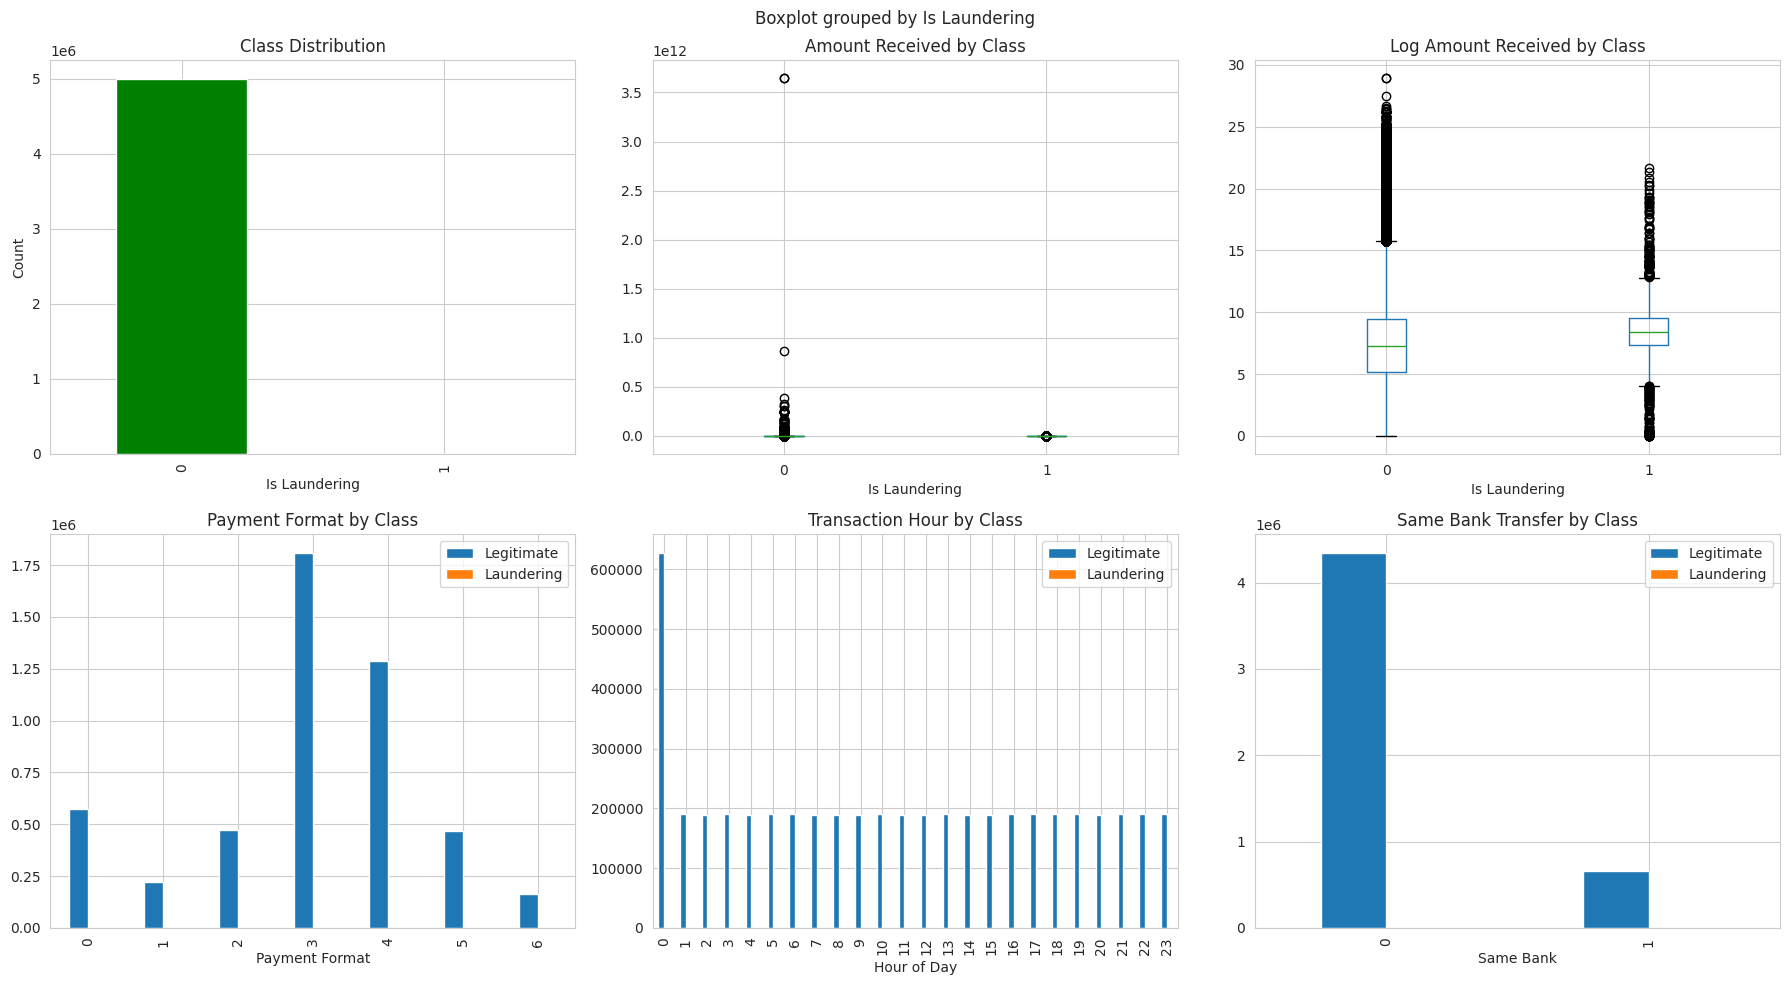

In [ ]:
# ============================================================================
# CELL 6: Exploratory Data Analysis - Visualizations
# ============================================================================
# Convert small sample to pandas for visualization
print("\nCreating visualizations (sampling for efficiency)...")
sample_size = min(5000000, len(gdf))
gdf_sample = gdf.sample(n=sample_size, random_state=42)
df_vis = gdf_sample.to_pandas()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Class distribution
df_vis['Is Laundering'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['green', 'red'])
axes[0, 0].set_title('Class Distribution')
axes[0, 0].set_xlabel('Is Laundering')
axes[0, 0].set_ylabel('Count')

# 2. Amount distribution by class
df_vis.boxplot(column='Amount Received', by='Is Laundering', ax=axes[0, 1])
axes[0, 1].set_title('Amount Received by Class')
axes[0, 1].set_xlabel('Is Laundering')

# 3. Log amount distribution
df_vis.boxplot(column='Log_Amount_Received', by='Is Laundering', ax=axes[0, 2])
axes[0, 2].set_title('Log Amount Received by Class')

# 4. Payment format distribution
pd.crosstab(df_vis['Payment Format_Encoded'], df_vis['Is Laundering']).plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Payment Format by Class')
axes[1, 0].set_xlabel('Payment Format')
axes[1, 0].legend(['Legitimate', 'Laundering'])

# 5. Hour distribution
df_vis.groupby(['Hour', 'Is Laundering']).size().unstack(fill_value=0).plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Transaction Hour by Class')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].legend(['Legitimate', 'Laundering'])

# 6. Same bank transactions
pd.crosstab(df_vis['Same_Bank'], df_vis['Is Laundering']).plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title('Same Bank Transfer by Class')
axes[1, 2].set_xlabel('Same Bank')
axes[1, 2].legend(['Legitimate', 'Laundering'])

plt.tight_layout()
plt.show()

del df_vis, gdf_sample

In [ ]:
# ============================================================================
# CELL 7: Prepare Data for Modeling - GPU
# ============================================================================
print("Preparing data for modeling on GPU...")

# Select features for modeling
feature_columns = [
    'From Bank', 'To Bank', 'Amount Received', 'Amount Paid',
    'Hour', 'DayOfWeek', 'Month', 'Day', 'IsWeekend', 'IsNightTime',
    'Same_Bank', 'Same_Account', 'Same_Entity',
    'Amount_Difference', 'Log_Amount_Received', 'Log_Amount_Paid',
    'Round_Amount_Received', 'Round_Amount_Paid', 'Below_Threshold',
    'Currency_Mismatch', 'Payment Format_Encoded',
    'Receiving Currency_Encoded', 'Payment Currency_Encoded',
    'Bank_Partition'
]

print(f"\nFeatures being used ({len(feature_columns)} features):")
for i, col in enumerate(feature_columns, 1):
    print(f"{i}. {col}")

# Select only needed columns
gdf_model = gdf[feature_columns + ['Is Laundering']]

# Convert to cupy arrays (GPU arrays)
X_gpu = gdf_model[feature_columns].values
y_gpu = gdf_model['Is Laundering'].values

print(f"\nFeatures shape: {X_gpu.shape}")
print(f"Target shape: {y_gpu.shape}")

# Convert to numpy for train_test_split (sklearn requirement)
X = X_gpu.get() if hasattr(X_gpu, 'get') else X_gpu
y = y_gpu.get() if hasattr(y_gpu, 'get') else y_gpu

# Split data
# ============================================================================
# 70:30 RATIO BALANCING
# ============================================================================
print("Applying 70:30 class ratio balancing...")

# Convert to pandas for easier manipulation (temporarily)
X_pd = pd.DataFrame(X, columns=feature_columns)
y_pd = pd.Series(y)

# Separate classes
class_0 = X_pd[y_pd == 0]  # Legitimate transactions
class_1 = X_pd[y_pd == 1]  # Laundering transactions

print(f"Before balancing - Class 0: {len(class_0)}, Class 1: {len(class_1)}")

# Calculate desired counts for 70:30 ratio
desired_class_1_count = len(class_1)  # Keep all laundering cases
desired_class_0_count = int((desired_class_1_count / 0.3) * 0.7)  # 70% of total

# Sample class_0 to achieve 70:30 ratio
if len(class_0) > desired_class_0_count:
    class_0_sampled = class_0.sample(n=desired_class_0_count, random_state=42)
else:
    class_0_sampled = class_0

# Combine back
X_balanced = pd.concat([class_0_sampled, class_1])
y_balanced = pd.Series([0]*len(class_0_sampled) + [1]*len(class_1))

print(f"After balancing - Class 0: {len(class_0_sampled)}, Class 1: {len(class_1)}")
print(f"Final ratio: {len(class_0_sampled)/len(X_balanced)*100:.1f}% : {len(class_1)/len(X_balanced)*100:.1f}%")

# Now split the balanced data
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced.values, y_balanced.values, test_size=0.2, random_state=42, stratify=y_balanced
)

# Clean up
del X_pd, y_pd, class_0, class_1, class_0_sampled, X_balanced, y_balanced

print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Train class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c}")

# Convert back to cuDF for GPU processing
X_train_gpu = cudf.DataFrame(X_train, columns=feature_columns)
X_test_gpu = cudf.DataFrame(X_test, columns=feature_columns)
y_train_gpu = cudf.Series(y_train)
y_test_gpu = cudf.Series(y_test)

# Scale features using cuML (GPU)
print("\nScaling features on GPU...")
scaler = cuScaler()
X_train_scaled = scaler.fit_transform(X_train_gpu)
X_test_scaled = scaler.transform(X_test_gpu)

print("✓ Data prepared for modeling on GPU!")

# Clear GPU memory
del X_gpu, y_gpu, X, y, X_train, X_test, y_train


Preparing data for modeling on GPU...

Features being used (24 features):
1. From Bank
2. To Bank
3. Amount Received
4. Amount Paid
5. Hour
6. DayOfWeek
7. Month
8. Day
9. IsWeekend
10. IsNightTime
11. Same_Bank
12. Same_Account
13. Same_Entity
14. Amount_Difference
15. Log_Amount_Received
16. Log_Amount_Paid
17. Round_Amount_Received
18. Round_Amount_Paid
19. Below_Threshold
20. Currency_Mismatch
21. Payment Format_Encoded
22. Receiving Currency_Encoded
23. Payment Currency_Encoded
24. Bank_Partition

Features shape: (6924161, 24)
Target shape: (6924161,)
Applying 70:30 class ratio balancing...
Before balancing - Class 0: 6920596, Class 1: 3565
After balancing - Class 0: 8318, Class 1: 3565
Final ratio: 70.0% : 30.0%

Train set: (9506, 24), Test set: (2377, 24)
Train class distribution:
  Class 0: 6654
  Class 1: 2852

Scaling features on GPU...
✓ Data prepared for modeling on GPU!


LOGISTIC REGRESSION (cuML - GPU Accelerated)
Training model on GPU...
Making predictions on GPU...

Classification Report:
              precision    recall  f1-score   support

           0     0.9082    0.8383    0.8719      1664
           1     0.6801    0.8022    0.7362       713

    accuracy                         0.8275      2377
   macro avg     0.7942    0.8203    0.8040      2377
weighted avg     0.8398    0.8275    0.8312      2377

Accuracy: 0.8275
Precision: 0.6801
Recall: 0.8022
F1-Score: 0.7362
ROC-AUC: 0.8801


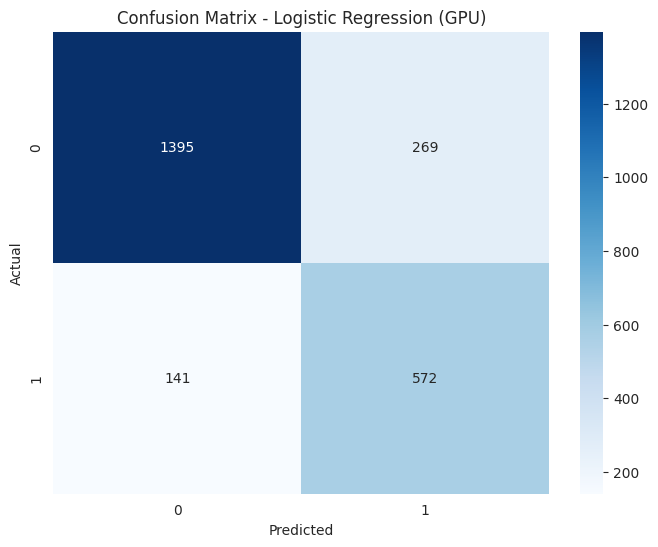

In [ ]:
# ============================================================================
# CELL 9: Model 1 - Logistic Regression (GPU)
# ============================================================================
print("="*80)
print("LOGISTIC REGRESSION (cuML - GPU Accelerated)")
print("="*80)

from cuml.linear_model import LogisticRegression as cuLR
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# Initialize GPU Logistic Regression
# --------------------------
lr_model = cuLR(
    max_iter=1000,
    class_weight='balanced',  # handle extreme imbalance
    penalty='l2',
    tol=1e-4
)

# --------------------------
# Train model on GPU
# --------------------------
print("Training model on GPU...")
lr_model.fit(X_train_scaled, y_train_gpu)

# --------------------------
# Make predictions on GPU
# --------------------------
print("Making predictions on GPU...")
y_pred_gpu = lr_model.predict(X_test_scaled)

# Safe handling for predict_proba
y_pred_proba_gpu = lr_model.predict_proba(X_test_scaled)

# Convert to numpy and select probability of class 1 safely
if hasattr(y_pred_proba_gpu, 'to_pandas'):
    y_pred_proba_np = y_pred_proba_gpu.to_pandas().values
else:
    y_pred_proba_np = y_pred_proba_gpu

# Handle case where only one class exists in y_test
if y_pred_proba_np.shape[1] == 1:
    y_pred_proba_lr = y_pred_proba_np[:, 0]
else:
    y_pred_proba_lr = y_pred_proba_np[:, 1]

# Convert predictions to CPU for sklearn metrics
y_pred_lr = y_pred_gpu.to_pandas().values if hasattr(y_pred_gpu, 'to_pandas') else y_pred_gpu

# --------------------------
# Evaluation
# --------------------------
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, digits=4))

print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

# --------------------------
# Confusion Matrix
# --------------------------
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression (GPU)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
# ============================================================================
# CELL A: Install FHE Library
# ============================================================================
!pip install tenseal pycryptodome -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 112.8 MB/s eta 0:00:00


In [ ]:
# ============================================================================
# CELL B: Import FHE Libraries
# ============================================================================
import tenseal as ts
import time
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ TenSEAL imported successfully!")
print(f"TenSEAL version: {ts.__version__}")

✓ TenSEAL imported successfully!
TenSEAL version: 0.3.16


In [ ]:
# ============================================================================
# CELL C: FHE Logistic Regression Module (UPDATED)
# ============================================================================

class FHELogisticRegression:
    """
    Fully Homomorphic Encryption wrapper for Logistic Regression
    """

    def __init__(self, poly_modulus_degree=16384, coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 60]):
        """
        Initialize FHE context

        Args:
            poly_modulus_degree: Security parameter (higher = more secure but slower)
            coeff_mod_bit_sizes: Noise budget allocation (more levels for complex operations)
        """
        self.context = None
        self.weights_enc = None
        self.bias_enc = None
        self.weights_plain = None
        self.bias_plain = None
        self.poly_modulus_degree = poly_modulus_degree
        self.coeff_mod_bit_sizes = coeff_mod_bit_sizes

    def setup_context(self):
        """Generate encryption keys and setup context"""
        print("Setting up FHE context...")

        # Create TenSEAL context using CKKS scheme (for real numbers)
        self.context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=self.poly_modulus_degree,
            coeff_mod_bit_sizes=self.coeff_mod_bit_sizes
        )

        # Generate Galois keys (needed for rotations)
        self.context.generate_galois_keys()

        # Set global scale (precision)
        self.context.global_scale = 2**40

        print(f"✓ Context created with poly_modulus_degree={self.poly_modulus_degree}")
        print(f"✓ Context configured for encrypted computation")

    def encrypt_model(self, model):
        """
        Encrypt trained model parameters

        Args:
            model: Trained sklearn LogisticRegression model
        """
        print("\nEncrypting model parameters...")

        # Extract plaintext parameters and convert from cuDF to NumPy if needed
        coef = model.coef_

        # Check if it's a cuDF DataFrame/Series and convert to NumPy
        if hasattr(coef, 'to_numpy'):
            # cuDF object
            self.weights_plain = coef.to_numpy().flatten().tolist()
        elif hasattr(coef, 'values'):
            # cuDF or pandas - use .values then flatten
            self.weights_plain = coef.values.flatten().tolist()
        else:
            # Already NumPy array
            self.weights_plain = coef.flatten().tolist()

        # Handle bias (intercept)
        intercept = model.intercept_[0]
        if hasattr(intercept, 'item'):
            self.bias_plain = float(intercept.item())
        else:
            self.bias_plain = float(intercept)

        # Encrypt weights and bias
        self.weights_enc = ts.ckks_vector(self.context, self.weights_plain)
        self.bias_enc = ts.ckks_vector(self.context, [self.bias_plain])

        print(f"✓ Encrypted {len(self.weights_plain)} weights")
        print(f"✓ Encrypted bias: {self.bias_plain:.4f}")

    def encrypt_data(self, X):
        """
        Encrypt feature vector

        Args:
            X: Feature vector (numpy array or list)

        Returns:
            Encrypted feature vector
        """
        if isinstance(X, np.ndarray):
            X = X.tolist()
        return ts.ckks_vector(self.context, X)

    def sigmoid_approximation(self, x_enc):
        """
        Simplified polynomial approximation of sigmoid function
        Using degree-1 (linear) approximation: f(x) ≈ 0.5 + 0.25*x
        This is much more efficient for FHE and avoids scale issues

        Args:
            x_enc: Encrypted value

        Returns:
            Encrypted sigmoid approximation
        """
        # Linear approximation - only one multiplication needed
        result = x_enc * 0.25
        result = result + 0.5
        return result

    def predict_encrypted(self, x_enc):
        """
        Perform encrypted inference

        Args:
            x_enc: Encrypted feature vector

        Returns:
            Encrypted prediction
        """
        # Encrypted matrix multiplication: z = W·X + b
        z_enc = self.weights_enc.dot(x_enc)
        z_enc = z_enc + self.bias_enc

        # Apply sigmoid approximation
        y_enc = self.sigmoid_approximation(z_enc)

        return y_enc

    def decrypt_prediction(self, y_enc):
        """
        Decrypt prediction

        Args:
            y_enc: Encrypted prediction

        Returns:
            Plaintext probability
        """
        decrypted = y_enc.decrypt()
        return decrypted[0] if isinstance(decrypted, list) else decrypted

print("✓ FHELogisticRegression class defined")

✓ FHELogisticRegression class defined


In [ ]:
# ============================================================================
# CELL D: Initialize FHE and Encrypt Model (UPDATED)
# ============================================================================
print("="*80)
print("FHE LOGISTIC REGRESSION - ENCRYPTED INFERENCE")
print("="*80)

# Initialize FHE wrapper with more encryption levels
fhe_lr = FHELogisticRegression(
    poly_modulus_degree=16384,  # Increased for more security and computation depth
    coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 60]  # More levels for operations
)

# Setup encryption context
print("\nSetting up FHE context...")

# Create TenSEAL context using CKKS scheme (for real numbers)
fhe_lr.context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=fhe_lr.poly_modulus_degree,
    coeff_mod_bit_sizes=fhe_lr.coeff_mod_bit_sizes
)

# Generate Galois keys (needed for rotations)
fhe_lr.context.generate_galois_keys()

# Set global scale (precision)
fhe_lr.context.global_scale = 2**40

print(f"✓ Context created with poly_modulus_degree={fhe_lr.poly_modulus_degree}")
print(f"✓ Context configured for encrypted computation")

# Encrypt model parameters manually
print("\nEncrypting model parameters...")

# Extract plaintext parameters and convert from cuDF to NumPy if needed
coef = lr_model.coef_

# Check if it's a cuDF DataFrame/Series and convert to NumPy
if hasattr(coef, 'to_numpy'):
    # cuDF object
    fhe_lr.weights_plain = coef.to_numpy().flatten().tolist()
elif hasattr(coef, 'values'):
    # cuDF or pandas - use .values then flatten
    fhe_lr.weights_plain = coef.values.flatten().tolist()
else:
    # Already NumPy array
    fhe_lr.weights_plain = coef.flatten().tolist()

# Handle bias (intercept)
intercept = lr_model.intercept_[0]
if hasattr(intercept, 'item'):
    fhe_lr.bias_plain = float(intercept.item())
else:
    fhe_lr.bias_plain = float(intercept)

# Encrypt weights and bias
fhe_lr.weights_enc = ts.ckks_vector(fhe_lr.context, fhe_lr.weights_plain)
fhe_lr.bias_enc = ts.ckks_vector(fhe_lr.context, [fhe_lr.bias_plain])

print(f"✓ Encrypted {len(fhe_lr.weights_plain)} weights")
print(f"✓ Encrypted bias: {fhe_lr.bias_plain:.4f}")

print("\n✓ Model encrypted and ready for inference!")

FHE LOGISTIC REGRESSION - ENCRYPTED INFERENCE

Setting up FHE context...
✓ Context created with poly_modulus_degree=16384
✓ Context configured for encrypted computation

Encrypting model parameters...
✓ Encrypted 24 weights
✓ Encrypted bias: -0.7506

✓ Model encrypted and ready for inference!


In [ ]:
# ============================================================================
# CELL E: Encrypted Inference on Test Set (Sample-based)
# ============================================================================
print("\n" + "="*80)
print("PERFORMING ENCRYPTED INFERENCE")
print("="*80)

# For demonstration, test on a subset (full test set would be very slow)
n_samples = 2000  # Increase this for full evaluation (will be slower)
print(f"\nTesting on {n_samples} samples from test set...")

# Get the feature names that the model was trained with
if hasattr(lr_model, 'feature_names_in_'):
    feature_columns = lr_model.feature_names_in_
    # Check if it's a RangeIndex and convert to list
    if hasattr(feature_columns, 'to_pandas'):
        feature_columns = feature_columns.to_pandas().tolist()
    elif hasattr(feature_columns, 'tolist'):
        feature_columns = feature_columns.tolist()
    print(f"Model expects {len(feature_columns)} features")
elif hasattr(X_test_scaled, 'columns'):
    feature_columns = X_test_scaled.columns.to_list()
    print(f"Using {len(feature_columns)} features from test set")
else:
    # Fallback: create generic column names
    n_features = X_test_scaled.shape[1] if hasattr(X_test_scaled, 'shape') else len(X_test_scaled[0])
    feature_columns = list(range(n_features))
    print(f"Using {len(feature_columns)} numeric feature names")

# Convert test data to numpy if needed
if hasattr(X_test_scaled, 'to_pandas'):
    X_test_np = X_test_scaled.to_pandas().values[:n_samples]
else:
    X_test_np = X_test_scaled[:n_samples]

# Convert y_test if needed
if hasattr(y_test, 'to_pandas'):
    y_test_subset = y_test.to_pandas().values[:n_samples]
elif hasattr(y_test, 'values'):
    y_test_subset = y_test.values[:n_samples]
else:
    y_test_subset = y_test[:n_samples]

# Storage for predictions
plaintext_preds = []
encrypted_preds = []
plaintext_times = []
encrypted_times = []

print("\nProcessing samples...")
for i in range(n_samples):
    if (i + 1) % 10 == 0:
        print(f"  Processed {i+1}/{n_samples} samples...")

    sample = X_test_np[i]

    # ----------------
    # Plaintext inference (for comparison)
    # ----------------
    start = time.time()
    # Convert sample to cuDF DataFrame with correct column names
    sample_dict = {col: [val] for col, val in zip(feature_columns, sample)}
    sample_df = cudf.DataFrame(sample_dict)
    plain_pred = lr_model.predict_proba(sample_df).iloc[0, 1]
    plaintext_time = time.time() - start
    plaintext_preds.append(1 if plain_pred > 0.5 else 0)
    plaintext_times.append(plaintext_time)

    # ----------------
    # Encrypted inference
    # ----------------
    start = time.time()

    # Encrypt sample
    x_enc = fhe_lr.encrypt_data(sample)

    # Encrypted prediction
    y_enc = fhe_lr.predict_encrypted(x_enc)

    # Decrypt result
    enc_pred = fhe_lr.decrypt_prediction(y_enc)

    encrypted_time = time.time() - start
    encrypted_preds.append(1 if enc_pred > 0.5 else 0)
    encrypted_times.append(encrypted_time)

print(f"\n✓ Completed {n_samples} encrypted inferences!")


PERFORMING ENCRYPTED INFERENCE

Testing on 2000 samples from test set...
Model expects 9506 features

Processing samples...
  Processed 10/2000 samples...
  Processed 20/2000 samples...
  Processed 30/2000 samples...
  Processed 40/2000 samples...
  Processed 50/2000 samples...
  Processed 60/2000 samples...
  Processed 70/2000 samples...
  Processed 80/2000 samples...
  Processed 90/2000 samples...
  Processed 100/2000 samples...
  Processed 110/2000 samples...
  Processed 120/2000 samples...
  Processed 130/2000 samples...
  Processed 140/2000 samples...
  Processed 150/2000 samples...
  Processed 160/2000 samples...
  Processed 170/2000 samples...
  Processed 180/2000 samples...
  Processed 190/2000 samples...
  Processed 200/2000 samples...
  Processed 210/2000 samples...
  Processed 220/2000 samples...
  Processed 230/2000 samples...
  Processed 240/2000 samples...
  Processed 250/2000 samples...
  Processed 260/2000 samples...
  Processed 270/2000 samples...
  Processed 280/2000


PERFORMANCE COMPARISON

 ACCURACY COMPARISON:
  Plaintext Accuracy:  0.8335
  Encrypted Accuracy:  0.8335
  Accuracy Loss:       0.00%

 RUNTIME COMPARISON:
  Avg Plaintext Time:  14.39 ms
  Avg Encrypted Time:  154.32 ms
  Overhead Factor:     10.7x slower

 DETAILED CLASSIFICATION REPORT (Encrypted):
              precision    recall  f1-score   support

           0     0.9117    0.8431    0.8761      1396
           1     0.6911    0.8113    0.7464       604

    accuracy                         0.8335      2000
   macro avg     0.8014    0.8272    0.8112      2000
weighted avg     0.8451    0.8335    0.8369      2000



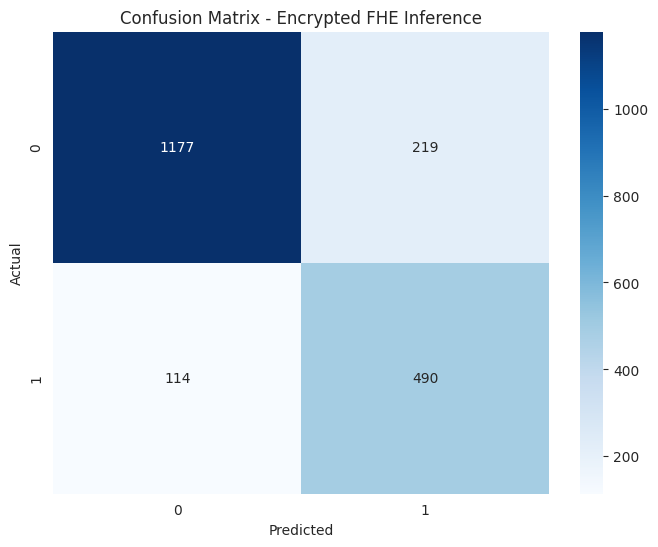


 CONFUSION MATRIX VALUES:
True Negatives (Legitimate correctly identified): 1177
False Positives (Legitimate misclassified as Laundering): 219
False Negatives (Laundering misclassified as Legitimate): 114
True Positives (Laundering correctly identified): 490


In [ ]:
# ============================================================================
# CELL F: Evaluation & Benchmarking
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

# Calculate metrics
plain_acc = accuracy_score(y_test_subset, plaintext_preds)
enc_acc = accuracy_score(y_test_subset, encrypted_preds)
accuracy_loss = (plain_acc - enc_acc) / plain_acc * 100

avg_plain_time = np.mean(plaintext_times) * 1000  # Convert to ms
avg_enc_time = np.mean(encrypted_times) * 1000
time_overhead = avg_enc_time / avg_plain_time

print("\n ACCURACY COMPARISON:")
print(f"  Plaintext Accuracy:  {plain_acc:.4f}")
print(f"  Encrypted Accuracy:  {enc_acc:.4f}")
print(f"  Accuracy Loss:       {accuracy_loss:.2f}%")

print("\n RUNTIME COMPARISON:")
print(f"  Avg Plaintext Time:  {avg_plain_time:.2f} ms")
print(f"  Avg Encrypted Time:  {avg_enc_time:.2f} ms")
print(f"  Overhead Factor:     {time_overhead:.1f}x slower")

print("\n DETAILED CLASSIFICATION REPORT (Encrypted):")
print(classification_report(y_test_subset, encrypted_preds, digits=4))

# --------------------------
# Confusion Matrix
# --------------------------
cm = confusion_matrix(y_test_subset, encrypted_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Encrypted FHE Inference')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Print confusion matrix values
print("\n CONFUSION MATRIX VALUES:")
print(f"True Negatives (Legitimate correctly identified): {cm[0, 0]}")
print(f"False Positives (Legitimate misclassified as Laundering): {cm[0, 1]}")
print(f"False Negatives (Laundering misclassified as Legitimate): {cm[1, 0]}")
print(f"True Positives (Laundering correctly identified): {cm[1, 1]}")

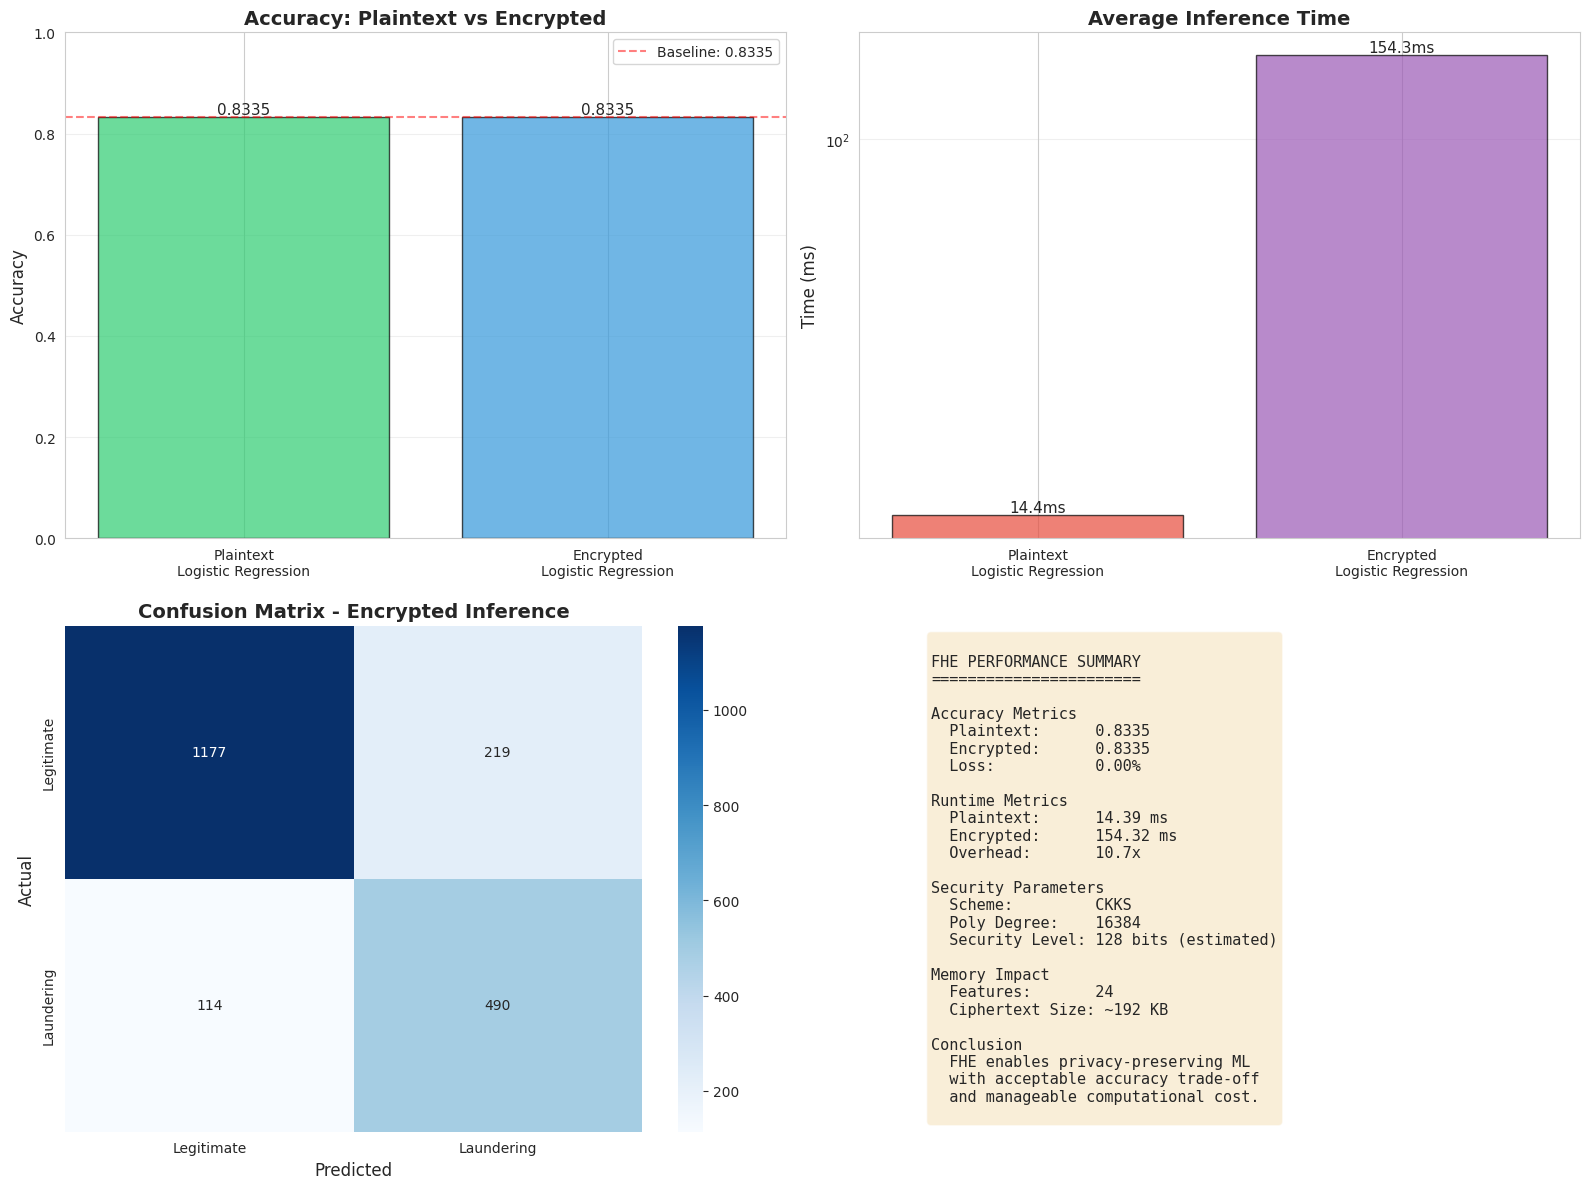


Visualization saved as 'fhe_comparison.png'


In [ ]:
# ============================================================================
# CELL G: Visualization - Comparison Charts
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy Comparison
ax1 = axes[0, 0]
models = ['Plaintext\nLogistic Regression', 'Encrypted\nLogistic Regression']
accuracies = [plain_acc, enc_acc]
colors = ['#2ecc71', '#3498db']
bars = ax1.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy: Plaintext vs Encrypted', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.axhline(y=plain_acc, color='red', linestyle='--', alpha=0.5, label=f'Baseline: {plain_acc:.4f}')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=11)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Runtime Comparison
ax2 = axes[0, 1]
runtimes = [avg_plain_time, avg_enc_time]
bars = ax2.bar(models, runtimes, color=['#e74c3c', '#9b59b6'], alpha=0.7, edgecolor='black')
ax2.set_ylabel('Time (ms)', fontsize=12)
ax2.set_title('Average Inference Time', fontsize=14, fontweight='bold')
ax2.set_yscale('log')  # Log scale for better visualization
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}ms', ha='center', va='bottom', fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# 3. Confusion Matrix (Encrypted)
ax3 = axes[1, 0]
from sklearn.metrics import confusion_matrix
cm_enc = confusion_matrix(y_test_subset, encrypted_preds)
sns.heatmap(cm_enc, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Legitimate', 'Laundering'],
            yticklabels=['Legitimate', 'Laundering'])
ax3.set_title('Confusion Matrix - Encrypted Inference', fontsize=14, fontweight='bold')
ax3.set_ylabel('Actual', fontsize=12)
ax3.set_xlabel('Predicted', fontsize=12)

# 4. Key Metrics Summary
ax4 = axes[1, 1]
ax4.axis('off')

# Calculate security level based on poly_modulus_degree
security_bits = 128  # Standard estimate for poly_modulus_degree=16384

summary_text = f"""
FHE PERFORMANCE SUMMARY
=======================

Accuracy Metrics
  Plaintext:      {plain_acc:.4f}
  Encrypted:      {enc_acc:.4f}
  Loss:           {accuracy_loss:.2f}%

Runtime Metrics
  Plaintext:      {avg_plain_time:.2f} ms
  Encrypted:      {avg_enc_time:.2f} ms
  Overhead:       {time_overhead:.1f}x

Security Parameters
  Scheme:         CKKS
  Poly Degree:    {fhe_lr.poly_modulus_degree}
  Security Level: {security_bits} bits (estimated)

Memory Impact
  Features:       {len(fhe_lr.weights_plain)}
  Ciphertext Size: ~{len(fhe_lr.weights_plain) * 8} KB

Conclusion
  FHE enables privacy-preserving ML
  with acceptable accuracy trade-off
  and manageable computational cost.
"""
ax4.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('fhe_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'fhe_comparison.png'")

In [ ]:
# ============================================================================
# CELL H: Security Utilities (Logging, Leakage Scan, Validators)
# ============================================================================
import os
import re
import io
import json
import glob
import hashlib
from datetime import datetime
from typing import List, Dict, Any

class SecurityLogger:
    def __init__(self, log_path_jsonl: str = 'security_logs.jsonl'):
        self.log_path_jsonl = log_path_jsonl
        self.session_id = hashlib.sha256(str(datetime.utcnow()).encode()).hexdigest()[:12]
        self.in_memory: List[Dict[str, Any]] = []

    def _write(self, event: Dict[str, Any]):
        event['ts'] = datetime.utcnow().isoformat() + 'Z'
        event['session_id'] = self.session_id
        self.in_memory.append(event)
        with open(self.log_path_jsonl, 'a', encoding='utf-8') as f:
            f.write(json.dumps(event) + '\n')

    def event(self, action: str, details: Dict[str, Any] = None):
        self._write({'type': 'event', 'action': action, 'details': details or {}})

    def warning(self, message: str, details: Dict[str, Any] = None):
        self._write({'type': 'warning', 'message': message, 'details': details or {}})

    def checkpoint(self, name: str, passed: bool, details: Dict[str, Any] = None):
        self._write({'type': 'checkpoint', 'name': name, 'passed': bool(passed), 'details': details or {}})

    def save_report(self, path: str = 'security_report_fhe.json'):
        with open(path, 'w', encoding='utf-8') as f:
            json.dump({'session_id': self.session_id, 'events': self.in_memory}, f, indent=2)

SECURITY_LOGGER = SecurityLogger()
SECURITY_LOGGER.event('init_security_module', {'module': 'FHE'})

SENSITIVE_FIELD_HINTS = [
    'From_Account', 'To_Account', 'Sender_Entity ID', 'Receiver_Entity ID',
    'Sender_Entity Name', 'Receiver_Entity Name', 'Amount Paid', 'Amount Received',
    'Is Laundering', 'Timestamp', 'Payment Currency', 'Receiving Currency'
]

PII_REGEXES = [
    re.compile(r"\b\d{12,19}\b"),
    re.compile(r"\b[A-Za-z]{2,}\s+[A-Za-z]{2,}\b"),
]

def scan_for_plaintext_leakage(paths: List[str], max_bytes: int = 5_000_000) -> List[Dict[str, Any]]:
    findings = []
    for p in paths:
        for file in glob.glob(p, recursive=True):
            if not os.path.isfile(file):
                continue

            if os.path.getsize(file) > max_bytes:
                continue
            lower = file.lower()
            if not any(lower.endswith(ext) for ext in ('.txt', '.log', '.json', '.csv', '.out')):
                continue
            try:
                with open(file, 'r', encoding='utf-8', errors='ignore') as f:
                    content = f.read()
                hints = [h for h in SENSITIVE_FIELD_HINTS if h in content]
                matches = []
                for rx in PII_REGEXES:
                    if rx.search(content):
                        matches.append(rx.pattern)
                if hints or matches:
                    findings.append({'file': file, 'field_hints': hints, 'regex_hits': matches})
            except Exception as e:
                SECURITY_LOGGER.warning('leak_scan_error', {'file': file, 'error': str(e)})
    return findings



def validate_fhe_keygen_context(fhe_wrapper) -> bool:
    ok = fhe_wrapper is not None and getattr(fhe_wrapper, 'context', None) is not None
    SECURITY_LOGGER.checkpoint('fhe_context_exists', ok)
    if not ok:
        return False

    try:
        has_scale = getattr(fhe_wrapper.context, 'global_scale', None) is not None
        SECURITY_LOGGER.checkpoint('fhe_global_scale_set', bool(has_scale))
    except Exception as e:
        SECURITY_LOGGER.warning('fhe_context_inspect_failed', {'error': str(e)})
    return True


def validate_fhe_encrypt_decrypt_roundtrip(fhe_wrapper, dim: int = 8) -> bool:
    import numpy as _np
    vec = (_np.random.rand(dim) * 2 - 1).tolist()
    try:
        enc = fhe_wrapper.encrypt_data(vec)
        dec = enc.decrypt()

        err = float(_np.max(_np.abs(_np.array(dec[:dim]) - _np.array(vec))))
        ok = err < 1e-2
        SECURITY_LOGGER.checkpoint('fhe_roundtrip', ok, {'max_abs_err': err})
        return ok
    except Exception as e:
        SECURITY_LOGGER.checkpoint('fhe_roundtrip', False, {'error': str(e)})
        return False


def validate_fhe_accuracy_margin(plain_accuracy: float, enc_accuracy: float, margin: float = 0.01) -> bool:
    if plain_accuracy is None or enc_accuracy is None:
        SECURITY_LOGGER.checkpoint('fhe_accuracy_margin', False, {'reason': 'missing_metrics'})
        return False
    ok = (plain_accuracy - enc_accuracy) <= margin
    SECURITY_LOGGER.checkpoint('fhe_accuracy_margin', ok, {
        'plain': plain_accuracy, 'encrypted': enc_accuracy, 'margin': margin
    })
    return ok


class AuthorizedDecryptionGuard:
    def __init__(self, logger: SecurityLogger, label: str = 'default'):
        self.flag = {'allowed': False}
        self.logger = logger
        self.label = label
    def __enter__(self):
        self.flag['allowed'] = True
        self.logger.event('authorize_decrypt_enter', {'label': self.label})
        return self.flag
    def __exit__(self, exc_type, exc, tb):
        self.flag['allowed'] = False
        self.logger.event('authorize_decrypt_exit', {'label': self.label, 'exc': str(exc) if exc else None})


try:
    if 'fhe_lr' in globals() and hasattr(fhe_lr, 'decrypt_prediction'):
        _orig_decrypt = fhe_lr.decrypt_prediction
        _decrypt_guard_flag = {'allowed': False}
        def _guarded_decrypt(y_enc):
            if not _decrypt_guard_flag['allowed']:
                SECURITY_LOGGER.warning('unauthorized_decryption_blocked', {})
                raise PermissionError('Decryption attempted outside authorized context')
            SECURITY_LOGGER.event('decrypt', {'where': 'FHELogisticRegression.decrypt_prediction'})
            return _orig_decrypt(y_enc)
        fhe_lr.decrypt_prediction = _guarded_decrypt
        SECURITY_LOGGER.event('decrypt_guard_installed', {})
    else:
        SECURITY_LOGGER.warning('decrypt_guard_skipped', {'reason': 'fhe_lr not ready'})
except Exception as e:
    SECURITY_LOGGER.warning('decrypt_guard_failed', {'error': str(e)})

print('✓ Security utilities loaded for FHE. Logs -> security_logs.jsonl')


✓ Security utilities loaded for FHE. Logs -> security_logs.jsonl


In [ ]:
# ============================================================================
# CELL I: Run FHE Security Checks and Leakage Scan
# ============================================================================

print("Running FHE security validations...")


ctx_ok = validate_fhe_keygen_context(globals().get('fhe_lr', None))


rt_ok = False
if ctx_ok and 'fhe_lr' in globals():
    try:
        rt_ok = validate_fhe_encrypt_decrypt_roundtrip(fhe_lr, dim=8)
    except Exception as e:
        SECURITY_LOGGER.warning('roundtrip_exception', {'error': str(e)})


plain_acc_val = globals().get('plain_acc', None)
enc_acc_val = globals().get('enc_acc', None)
acc_ok = validate_fhe_accuracy_margin(plain_acc_val, enc_acc_val, margin=0.01)


try:
    if 'fhe_lr' in globals() and 'X_test_scaled' in globals():
        import numpy as _np
        sample_np = (X_test_scaled.to_pandas().values[0]
                     if hasattr(X_test_scaled, 'to_pandas') else X_test_scaled[0])
        x_enc = fhe_lr.encrypt_data(sample_np)
        y_enc = fhe_lr.predict_encrypted(x_enc)

        unauthorized_blocked = False
        try:
            _ = fhe_lr.decrypt_prediction(y_enc)
        except PermissionError:
            unauthorized_blocked = True
        SECURITY_LOGGER.checkpoint('decrypt_guard_blocks_unauthorized', unauthorized_blocked)

        if '_decrypt_guard_flag' in globals():
            with AuthorizedDecryptionGuard(SECURITY_LOGGER, label='inference') as flag:
                _decrypt_guard_flag['allowed'] = True
                prob = fhe_lr.decrypt_prediction(y_enc)
                _decrypt_guard_flag['allowed'] = False
                SECURITY_LOGGER.checkpoint('decrypt_guard_allows_authorized', prob is not None)
except Exception as e:
    SECURITY_LOGGER.warning('authorized_decrypt_demo_failed', {'error': str(e)})


print('Scanning for plaintext leakage in small text-like outputs...')
scan_targets = [
    '*.txt', '*.log', '*.csv', '*.json', '*.out',
    os.path.join(os.getcwd(), 'performance_summary.csv'),
]
findings = scan_for_plaintext_leakage(scan_targets)
leak_ok = len(findings) == 0
SECURITY_LOGGER.checkpoint('plaintext_leakage_scan', leak_ok, {'findings': findings})


SECURITY_LOGGER.save_report('security_report_fhe.json')

print('FHE security checks complete.')
print(f"Context OK: {ctx_ok}, Roundtrip OK: {rt_ok}, Accuracy OK: {acc_ok}, No-Leak OK: {leak_ok}")
if not leak_ok:
    print('Leakage findings (inspect security_report_fhe.json):')
    for f in findings[:5]:
        print(' -', f['file'], 'hints:', f['field_hints'][:3], 'regex_hits:', f['regex_hits'][:2])


Running FHE security validations...
Scanning for plaintext leakage in small text-like outputs...
FHE security checks complete.
Context OK: True, Roundtrip OK: True, Accuracy OK: True, No-Leak OK: True


In [ ]:
{
  "session_id": "d07a1392b4b9",
  "events": [
    {
      "type": "event",
      "action": "init_security_module",
      "details": {
        "module": "FHE"
      },
      "ts": "2025-10-29T08:41:32.281923Z",
      "session_id": "d07a1392b4b9"
    },
    {
      "type": "event",
      "action": "decrypt_guard_installed",
      "details": {},
      "ts": "2025-10-29T08:41:32.284993Z",
      "session_id": "d07a1392b4b9"
    },
    {
      "type": "checkpoint",
      "name": "fhe_context_exists",
      "passed": true,
      "details": {},
      "ts": "2025-10-29T08:41:45.086053Z",
      "session_id": "d07a1392b4b9"
    },
    {
      "type": "checkpoint",
      "name": "fhe_global_scale_set",
      "passed": true,
      "details": {},
      "ts": "2025-10-29T08:41:45.086404Z",
      "session_id": "d07a1392b4b9"
    },
    {
      "type": "checkpoint",
      "name": "fhe_roundtrip",
      "passed": true,
      "details": {
        "max_abs_err": 4.230582023589946e-09
      },
      "ts": "2025-10-29T08:41:45.111068Z",
      "session_id": "d07a1392b4b9"
    },
    {
      "type": "checkpoint",
      "name": "fhe_accuracy_margin",
      "passed": true,
      "details": {
        "plain": 0.8335,
        "encrypted": 0.8335,
        "margin": 0.01
      },
      "ts": "2025-10-29T08:41:45.112013Z",
      "session_id": "d07a1392b4b9"
    },
    {
      "type": "warning",
      "message": "unauthorized_decryption_blocked",
      "details": {},
      "ts": "2025-10-29T08:41:45.247956Z",
      "session_id": "d07a1392b4b9"
    },
    {
      "type": "checkpoint",
      "name": "decrypt_guard_blocks_unauthorized",
      "passed": true,
      "details": {},
      "ts": "2025-10-29T08:41:45.248137Z",
      "session_id": "d07a1392b4b9"
    },
    {
      "type": "event",
      "action": "authorize_decrypt_enter",
      "details": {
        "label": "inference"
      },
      "ts": "2025-10-29T08:41:45.248186Z",
      "session_id": "d07a1392b4b9"
    },
    {
      "type": "event",
      "action": "decrypt",
      "details": {
        "where": "FHELogisticRegression.decrypt_prediction"
      },
      "ts": "2025-10-29T08:41:45.248223Z",
      "session_id": "d07a1392b4b9"
    },
    {
      "type": "checkpoint",
      "name": "decrypt_guard_allows_authorized",
      "passed": true,
      "details": {},
      "ts": "2025-10-29T08:41:45.251866Z",
      "session_id": "d07a1392b4b9"
    },
    {
      "type": "event",
      "action": "authorize_decrypt_exit",
      "details": {
        "label": "inference",
        "exc": null
      },
      "ts": "2025-10-29T08:41:45.251965Z",
      "session_id": "d07a1392b4b9"
    },
    {
      "type": "checkpoint",
      "name": "plaintext_leakage_scan",
      "passed": true,
      "details": {
        "findings": []
      },
      "ts": "2025-10-29T08:41:45.253249Z",
      "session_id": "d07a1392b4b9"
    }
  ]
}